How many MCQ questions on this sheet [3]: 4
How many choices per question [4]: 4

Enter the correct choice for each question (letters A‑D).
  Q1: b
  Q2: b
  Q3: c
  Q4: d

Student answers: {1: ['B'], 2: ['B'], 3: ['C'], 4: ['D']}
Final score: 4 / 4


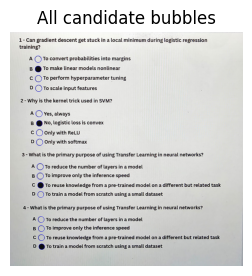

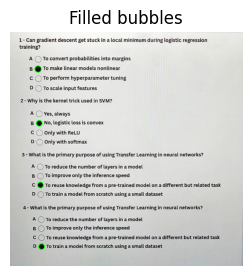

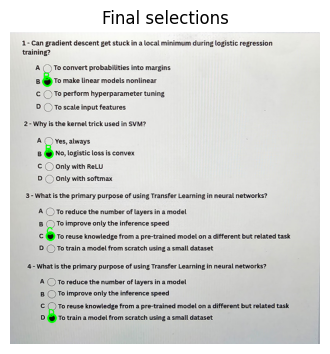

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import math
import string

def ask_int(prompt: str, default: int | None = None) -> int:
    """Prompt the user for a positive integer, supplying a default if desired."""
    while True:
        raw = input(f"{prompt}{' ['+str(default)+']' if default is not None else ''}: ").strip()
        if not raw and default is not None:
            return default
        if raw.isdigit() and int(raw) > 0:
            return int(raw)
        print("Please enter a positive integer.")

def get_sheet_parameters():
    """
    Ask the user for:
      * number of questions
      * number of choices per question
      * the answer key (typed manually)
    Returns a tuple: (num_questions, choices_per_question, answer_key_dict)
    """
    num_q   = ask_int("How many MCQ questions on this sheet", 3)
    choices = ask_int("How many choices per question",        4)
    valid   = list(string.ascii_uppercase[:choices])

    answer_key: dict[int, list[str]] = {}
    print(f"\nEnter the correct choice for each question (letters {valid[0]}‑{valid[-1]}).")
    for q in range(1, num_q + 1):
        while True:
            ans = input(f"  Q{q}: ").upper().strip()
            if ans in valid:
                answer_key[q] = [ans]
                break
            print(f"Use only one letter between {valid[0]} and {valid[-1]}.")
    return num_q, choices, answer_key

# 2. Image loading and preprocessing

def load_and_preprocess(img_path: str, width: int = 800):

    original = cv2.imread(img_path)
    if original is None:
        raise FileNotFoundError(f"Image not found at {img_path}")
    resized = cv2.resize(original, (width, int(original.shape[0] * width / original.shape[1])))
    gray    = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
    blur    = cv2.GaussianBlur(gray, (7, 7), 0)
    thresh  = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2
    )
    return resized, gray, thresh

# 3. Candidate and filled‑bubble detection

def find_candidates(thresh, area_range=(200, 5000), radius_range=(8, 15)):
    """Return list of (x, y, r) for contours that look like answer bubbles."""
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    candidates = []
    for c in contours:
        area = cv2.contourArea(c)
        if area_range[0] < area < area_range[1]:
            (x, y), r = cv2.minEnclosingCircle(c)
            if radius_range[0] < r < radius_range[1]:
                candidates.append((int(x), int(y), int(r)))
    return candidates

def filter_filled(candidates, gray, thresh, fill_ratio_min=0.5):
    """
    Keep only bubbles whose white‑pixel ratio inside the circle
    exceeds the given threshold.
    """
    filled = []
    for x, y, r in candidates:
        mask = np.zeros_like(gray)
        cv2.circle(mask, (x, y), r, 255, -1)
        filled_px = cv2.countNonZero(cv2.bitwise_and(thresh, thresh, mask=mask))
        ratio = filled_px / (math.pi * r * r)
        if ratio > fill_ratio_min:
            filled.append((x, y, r))
    return filled

# 4. Group bubbles into question rows

def group_questions(filled, candidates, num_questions):
    """
    Sort filled bubbles by vertical position and
    assign every candidate bubble to its closest filled bubble row.
    Returns (sorted_filled, row_groups_dict)
    """
    filled.sort(key=lambda t: t[1])        # top → bottom
    filled = filled[:num_questions]        # safeguard
    groups = defaultdict(list)
    for x, y, r in candidates:
        row = min(range(len(filled)), key=lambda i: abs(filled[i][1] - y))
        groups[row].append((x, y, r))
    return filled, groups

# 5. Extract student's selected answers and score

def determine_answers(filled, groups, choices_per_q):
    #Return a dict {question_number: [chosen_letter]}.
    answers = {}
    for qi, (fx, fy, _) in enumerate(filled, start=1):
        row = groups[qi - 1]
        unfilled_above = sum(1 for (_, y0, _) in row if y0 < fy)
        unfilled_above = min(unfilled_above, choices_per_q - 1)
        answers[qi] = [chr(ord('A') + unfilled_above)]
    return answers

def score_answers(student_answers, answer_key):
    """Return the numeric score compared to the provided answer key."""
    return sum(set(student_answers[q]) == set(answer_key[q]) for q in answer_key)

# 6. Visualisation helpers

def visualize(resized, candidates, filled, student_answers, answer_key):
    #Show three matplotlib figures illustrating detection and grading.
    # All candidate bubbles
    dbg = resized.copy()
    for x, y, r in candidates:
        cv2.circle(dbg, (x, y), r, (255, 0, 0), 1)
    plt.figure(figsize=(3, 5))
    plt.imshow(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB))
    plt.title("All candidate bubbles")
    plt.axis("off")

    # Filled bubbles
    dbg2 = resized.copy()
    for x, y, r in filled:
        cv2.circle(dbg2, (x, y), r, (0, 255, 0), 2)
    plt.figure(figsize=(3, 5))
    plt.imshow(cv2.cvtColor(dbg2, cv2.COLOR_BGR2RGB))
    plt.title("Filled bubbles")
    plt.axis("off")

    # Final selections
    vis = resized.copy()
    for qi, (x, y, r) in enumerate(filled, start=1):
        correct = student_answers[qi] == answer_key[qi]
        color   = (0, 255, 0) if correct else (0, 0, 255)
        cv2.circle(vis, (x, y), r, color, 3)
        cv2.putText(vis, student_answers[qi][0], (x - r, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, color, 2)

    plt.figure(figsize=(4, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title("Final selections")
    plt.axis("off")
    plt.show()


# 7. Main entry point

def main():
    IMG_PATH = "/content/4mcq.jpeg"

    # User input (last interactive step)
    num_q, choices_per_q, answer_key = get_sheet_parameters()

    # Image processing and grading
    resized, gray, thresh = load_and_preprocess(IMG_PATH)
    candidates = find_candidates(thresh)
    filled     = filter_filled(candidates, gray, thresh)

    if len(filled) < num_q:
        raise ValueError(f"Found only {len(filled)} filled bubbles, expected at least {num_q}")

    filled, groups   = group_questions(filled, candidates, num_q)
    student_answers  = determine_answers(filled, groups, choices_per_q)
    score            = score_answers(student_answers, answer_key)

    # Console output
    print("\nStudent answers:", student_answers)
    print(f"Final score: {score} / {num_q}")

    # Visual output
    visualize(resized, candidates, filled, student_answers, answer_key)

if __name__ == "__main__":
    main()
